# Linear Regression

This notebook goes over a basic linear regression implementation via gradient descent.

After implementing by hand, some sklearn benchmarks are compared, and we start to dig into some of the metrics used in regression.

In [2]:
# Useful libraries?
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

---
---
---
# Problem 1 - Optimization
---
***
___

In [3]:
# Import the advertising dataset
dat_adv = pd.read_csv("../Data/Advertising.csv")
dat_adv = dat_adv[['TV','Radio','Newspaper','Sales']]

In [3]:
# Take a look and pull out useful numbers
# We have TV, Radio, Newspaper as inputs, Sales as our output
# Note that the numbers are all rather large -> might want to scale
tv = 'TV'
radio = 'Radio'
news = 'Newspaper'
sales = 'Sales'

n = dat_adv.shape[0]   # Number of examples
p = dat_adv.shape[1]-1# Number of parameters, -2: 1 for X and one for Sales
dat_adv.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [92]:
# Let's create usable matrices to perform gradient descent

# Design Matrix
X = dat_adv[[tv,radio,news]].values
# We might need to normalize
Xscaled = (X - X.mean(0))/(np.std(X,axis=0)) 
# And as a DF
Xdf = dat_adv[[tv,radio,news]]
#Xdf['bias'] = np.ones((n,1))
Xdf = sm.add_constant(Xdf)

# Add a bias column
X = np.c_[np.ones(n), X]
Xscaled = np.c_[np.ones(n), Xscaled]

# Output variable of interest
y = dat_adv[sales].values
y = y.reshape(-1,1) # Make this 2 dimensional so that matrix multiplication works. 
ydf = dat_adv[[sales]]

In [5]:
# Create functions to calculate the gradient and the negative log likelihood (normalizing to 1/n)
# Note that the @ symbol does matrix multiplication

def negative_loglikelihood(X,y,beta):
    
    J = np.mean((y-X@beta)**2)

    return J

def gradient(X,y,beta):
    
    dbeta = -(X.T@y - X.T@X@beta)/len(y)
    
    return dbeta

In [6]:
# Gradient Descent
# Create function to calculate gradient descent
# Returns a matplotlib line(?) as well as the beta parameters

def gradDesc(betaInit,X,y,max_iter,learning_rate):

    beta = betaInit
    # Initialize cost vector and iteration vector for later plotting
    iter_vec = np.arange(max_iter)
    cost_vec = np.zeros(max_iter)

    for ii in range(max_iter):

        # Calculate the gradient
        dbeta = gradient(X,y,beta)

        # Update theta
        beta = beta - learning_rate * dbeta

        # Calculate the value of the log-likelihood
        cost = negative_loglikelihood(X,y,beta)
        #print(cost)

        # Save cost for later plotting
        cost_vec[ii] = cost

    
    # Create this to use later
    outputPlt = plt.plot(iter_vec,cost_vec)

            
    return outputPlt,beta


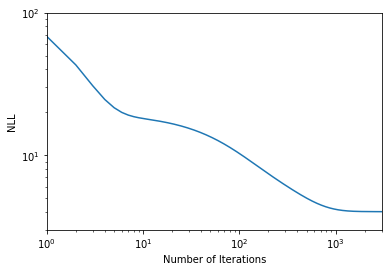

beta parameters:


,Sales
bias,0.015624
TV,0.053766
Radio,0.221514
Newspaper,0.017024


In [30]:
# Initialize Hyperparameters
lr = 1e-5
max_iter = 3000

# Initialize a beta set to use (zeros works here, but should be randomized down the line)
# Need p+1 parameters to account for bias
bInit = np.random.uniform(low=-0.1,high=0.1, size=(p+1,1))
bInit = np.zeros((p+1,1))

# Good guess based on linear model fit
#bInit = np.array([3,0,0,0]).reshape(-1,1)

# Perform gradient descent to get the guesses for beta
(gdplt,beta) = gradDesc(bInit,X,y,max_iter,lr)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('NLL')
plt.xlabel('Number of Iterations')
plt.axis([1, max_iter, 3, 100])
plt.show()

print("beta parameters:")
pd.DataFrame(beta,columns=['Sales'],index=['bias',tv,radio,news])

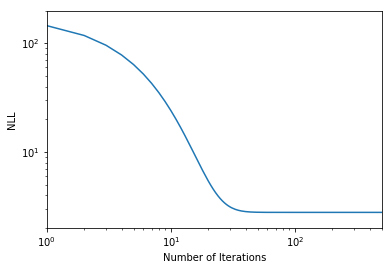

beta parameters:


,Sales
bias,14.022500
TV,3.919254
Radio,2.792063
Newspaper,-0.022539


In [26]:
# Do it again, but with the scaled data (converges much faster)
lr = 1e-1
max_iter = 500


(gd2,betaScaled) = gradDesc(bInit,Xscaled,y,max_iter,lr)
pd.DataFrame(betaScaled,columns=['Sales'],index=['intercept',tv,radio,news])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('NLL')
plt.xlabel('Number of Iterations')
plt.axis([1, max_iter, 2, 200])
plt.show()

print("beta parameters:")
pd.DataFrame(betaScaled,columns=['Sales'],index=['bias',tv,radio,news])

In [138]:
# Compare with the built in python tool from statmodels
fit = sm.OLS(ydf, Xdf).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 21 Jan 2019   Prob (F-statistic):           1.58e-96
Time:                        10:44:24   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
# Compare with standard linear regression (analytic solution)
betaOLS = np.linalg.inv(X.T @ X) @ X.T @ y
pd.DataFrame(betaOLS,columns=['Sales'],index=['bias',tv,radio,news])

,Sales
bias,2.938889
TV,0.045765
Radio,0.188530
Newspaper,-0.001037


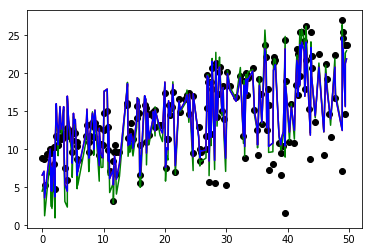

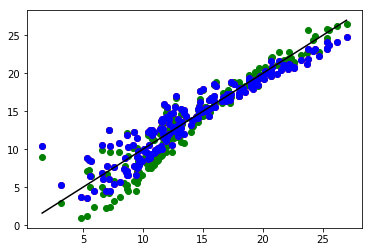

In [135]:
# This shows the y solution against one variable
# Can be changed to different variables, or change the regression above to 1D if you want a straight line
xvar = 2
xOrder = np.argsort(X,axis=0)[:,xvar]
# Couldn't figure out easy way to sort and plot, will leave for now. 
yhat = X@beta
yhatSM = fit.predict(Xdf)
yhatOLS = X@betaOLS
plt.plot(X[xOrder,xvar],y[xOrder],'ko')
plt.plot(X[xOrder,xvar],yhat[xOrder],color='green')
plt.plot(X[xOrder,xvar],yhatSM[xOrder],color='red')
plt.plot(X[xOrder,xvar],yhatOLS[xOrder],color='blue')
plt.show()

yorder = np.argsort(y,axis=0).reshape(-1)
plt.plot(y[yorder],yhat[yorder],'go')
plt.plot(y[yorder],yhatSM[yorder],'ro')
plt.plot(y[yorder],yhatOLS[yorder],'bo')
plt.plot(y[yorder],y[yorder],'k-')
plt.show()

In [143]:
# Compare all the final coefficients (too much effort to format..)
# It looks like Gradient Descent minimized to different places (if I force the bInit to the LM starting point, can probably get closer)
print('Gradient Descent')
print(beta)
print('\nPython sm method')
print(fit.params)
print('\nOLS Analytic')
print(betaOLS)

Gradient Descent
[[0.0156241 ]
 [0.05376577]
 [0.22151358]
 [0.0170239 ]]

Python sm method
const        2.938889
TV           0.045765
Radio        0.188530
Newspaper   -0.001037
dtype: float64

OLS Analytic
[[ 2.93888937e+00]
 [ 4.57646455e-02]
 [ 1.88530017e-01]
 [-1.03749304e-03]]


## Discussion

The gradient descent method does find a local minima, but it does not appear to find the global minima that you would arrive at via the normal equation. If I change my initial conditions it is possible for GD to converge on a similiar answer to SLM.

---
---
---
# Problem 2 - Interpretation
---
---
---

---
## Single Variable Regression

In [149]:
# Okay, let's dig into this a little bit. But sticking to lm as it gives us nice fancy statistics :)
# First, let's consider just the sales ~ newspaper relationship
fitNews = smf.ols('Sales~Newspaper',data=dat_adv).fit()

fitNews.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Mon, 21 Jan 2019   Prob (F-statistic):            0.00115
Time:                        14:32:45   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
Newspaper      0.0547      0.017      3.300      0.001       0.022       0.087
==============================================================================
Omnibus:                        6.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.483
Skew:                           0.330   Prob(JB):                       0.0645
Kurtosis:                       2.527   Cond. No.                         64.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
# Write a few functions to emulate regression and QQ plots
def residPlot(model):
    # fitted values (need a constant term for intercept)
    model_fitted_y = model.fittedvalues

    # model residuals
    model_residuals = model.resid
    
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)

    plot_resid = plt.figure()
    plot_resid.set_figheight(4)
    plot_resid.set_figwidth(6)

    plot_resid.axes[0] = sns.residplot(model_fitted_y, sales, data=dat_adv, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_resid.axes[0].set_title('Residuals vs Fitted')
    plot_resid.axes[0].set_xlabel('Fitted values')
    plot_resid.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_resid.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_residuals[i]));
        
    plt.show()
        
        
        
def qqPlot(model):
    
    # normalized residuals
    model_norm_residuals = model.get_influence().resid_studentized_internal
    
    QQ = ProbPlot(model_norm_residuals)

    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

    plot_lm_2.set_figheight(4)
    plot_lm_2.set_figwidth(6)

    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, 
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
        
    plt.show()
        
        

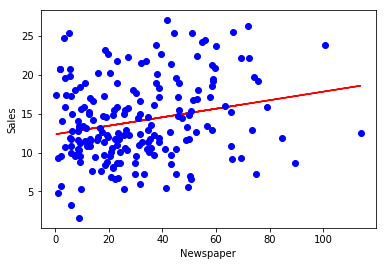

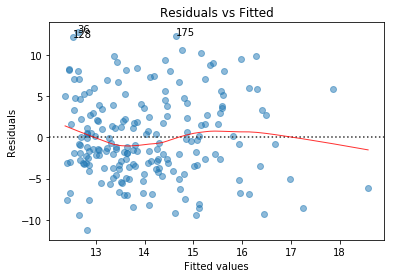

In [179]:
# Plot it and its residuals
plt.plot(Xdf[[news]],fitNews.fittedvalues,'-r')
plt.plot(Xdf[[news]],ydf,'ob')
plt.xlabel('Newspaper')
plt.ylabel('Sales')
plt.show()
residPlot(fitNews)

## Discussion: Simple Linear Regression

1. There does not appear to be a significant relationship between Newspaper and Sales: there is a spread about the line, and the R^2 statistic is very low.

    However, the p-value is very small, so it seems likely to reject the null (only 0.1% chance that this data can be explained by the null hypothesis). There is also no discernible pattern to worry about in the residuals. 

---
## Multivariate Regression

In [185]:
# Next, we do a multiple regression on all 3 variables
fitAll = smf.ols('Sales~TV+Radio+Newspaper',data=dat_adv).fit()
fitAll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 21 Jan 2019   Prob (F-statistic):           1.58e-96
Time:                        15:02:19   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

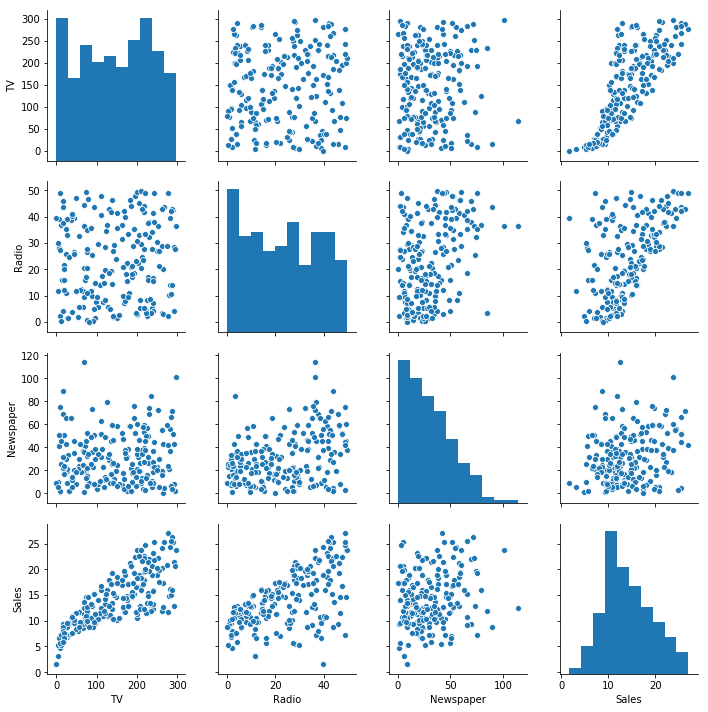

,TV,Radio,Newspaper,Sales
TV,1.0,0.054809,0.056648,0.782224
Radio,0.0,1.000000,0.354104,0.576223
Newspaper,0.0,0.000000,1.000000,0.228299
Sales,0.0,0.000000,0.000000,1.000000


In [197]:
# Let's also get some extra data about the relationships between parameters
# correlation matrix
sns.pairplot(dat_adv)
plt.show()
pd.DataFrame(np.triu(dat_adv.corr()),columns=dat_adv.columns,index=dat_adv.columns)

## Discussion: Multiple Linear Regression

2. Now that we have added the other variables, the p-value for Newspaper has increased to 86%. So it seems unlikely that this parameter is actually a good predictor after all. 

3. This *does* make sense, as we can see there is a reasonable correlation between radio and newspaper, and so the earlier simple linear regression was picking up the radio/sales relationship, essentially by accident. 

---
---
---
# Problem 3 - Assumptions and Diagnostics
---
---
---

## Discussion: Assumptions

1. Typically, we assume that the errors are **iid** (identical, independently distributed). Trends in residuals can point to this being false (ie. errors are heteroscedastic?).

    We also assume that they are uncorrelated, which may not always be the case.(eg. time series data)
    
    If the errors are well behaved then so should be the residuals (no patterns).
    
    Funnel shapes can indicate heteroscedasticity.
    
    QQ Plots can also tell us about the errors: normally distributed data would follow a straight line. Deviations from the line imply the errors are not all the same.

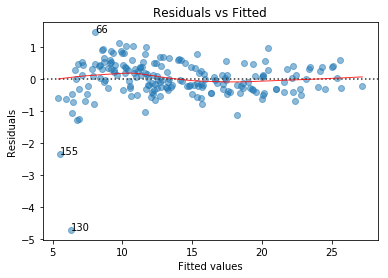

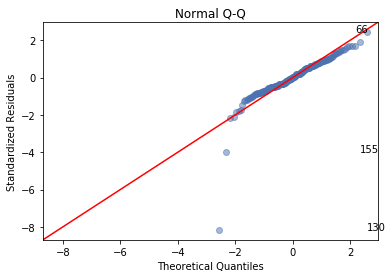

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1389.
Date:                Mon, 21 Jan 2019   Prob (F-statistic):          4.22e-171
Time:                        15:16:39   Log-Likelihood:                -182.61
No. Observations:                 200   AIC:                             387.2
Df Residuals:                     189   BIC:                             423.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.8636      0.325     14.947      0.000       4.222       5.505
TV                     0.0534      0.003     18.849      0.000       0.048       0.059
Radio                  0.0274      0.014      1.946      0.053      -0.000       0.055
TV:Radio               0.0011   6.64e-05     15.829      0.000       0.001       0.001
Newspaper              0.0156      0.012      1.322      0.188      -0.008       0.039
TV:Newspaper          -0.0001   6.43e-05     -1.638      0.103      -0.000    2.15e-05
Radio:Newspaper       -0.0002      0.000     -0.647      0.519      -0.001       0.000
TV:Radio:Newspaper  1.877e-06   1.87e-06      1.002      0.318   -1.82e-06    5.57e-06
I(TV ** 2)            -0.0001   6.99e-06    -15.794      0.000      -0.000   -9.67e-05
I(Radio ** 2)          0.0002      0.000      0.650      0.517      -0.000       0.001
I(Newspaper ** 2)   3.104e-05   7.58e-05      0.409      0.683      -0.000       0.000
==============================================================================
Omnibus:                      151.203   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2973.929
Skew:                          -2.573   Prob(JB):                         0.00
Kurtosis:                      21.177   Cond. No.                     1.66e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [207]:
# Let's make a few different models and see how they compare (only do 1 here, same as R otherwise)
# All up to order 3
fit8N = "All Interactions up to order 3"
fit8 = smf.ols('Sales~TV*Radio*Newspaper+I(TV**2)+I(Radio**2)+I(Newspaper**2)',data=dat_adv).fit()
residPlot(fit8)
qqPlot(fit8)
fit8.summary()

---
---
---
# Problem 4
---
---
---

# Discussion: Weighted Least Squares (Analytic)

We start with the model
$$y = Xb + \epsilon$$
$$\epsilon \sim \mathcal{N} \left(\mathbf{\mu}, diag(\sigma_1^2,\sigma_2^2,...,\sigma_n^2) \right)$$


We can write out a weight matrix:
$$W = diag(w_1,w_2,...,w_n)$$
$$w_i = \frac{1}{\sigma_i^2}$$

To get the weighted residual sum of squares:
$$ WRRS = \frac{1}{n}(y-Xb)^T W (y-Xb) $$

Which we can minimze and get new estimators for the data (note that I will use $J=WRSS$ for ease of notation):

$$ J = \sum_{i,j}(y_i-b_k X^T_{ki} ) W_{ij} (y_j - X_{jl}b_l) $$

$$ \frac{\partial J}{\partial b_m } = \sum_{i,j} 
-X^T_{mi} W_{ij} y_j - X_{mi}^T W_{ij} X_{jl} b_l + y_iW_{ij}X_{jm} - b_kX^T_{ki}W_{ij} X_{jm} = 0 $$

$$ \sum_{ij} \left(X^T_{mi}W_{ij}X_{jl}b_l+b_kX^T_{ki}W_{ij}X_{jm}\right) =
\sum_{ij} \left(X^T_{mi}W_{ij}y_j + y_iW_{ij}X_{jm}\right) 
 $$
 
Expressing this in matrix form:
 
$$ X^T W X b = X^T W y $$

$$b = \left(X^T W X \right)^{-1} X^T W y $$

In [219]:
# For lack of a better set of weights, we can use the standardized residuals from the linear fit to  estimate weights
# to do a weighted fit
# (Here we just stick to the simple linear fit that just uses TV, Radio, and Newspaper)

yhatOLS = X @ betaOLS
RSS = np.sum((y-yhatOLS)**2)
RSE = np.sqrt(RSS/(n-p-1))
resids = (y-yhatOLS)
stRes = resids/RSE
absSR = abs(stRes)
W = np.diag((absSR**2).reshape(-1))
betaWLS = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y

In [222]:
print("OLS")
print(betaOLS)
print("\n WLS")
print(betaWLS)

OLS
[[ 2.93888937e+00]
 [ 4.57646455e-02]
 [ 1.88530017e-01]
 [-1.03749304e-03]]

 WLS
[[0.36372922]
 [0.05234347]
 [0.12477706]
 [0.03846613]]


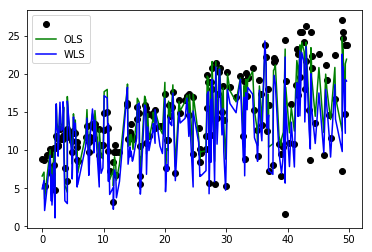

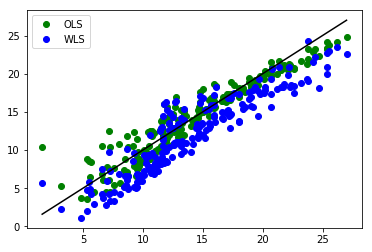

In [229]:
# This shows the y solution against one variable
# Can be changed to different variables, or change the regression above to 1D if you want a straight line
xvar = 2
xOrder = np.argsort(X,axis=0)[:,xvar]
yhat = X@beta
yhatSM = fit.predict(Xdf)
yhatOLS = X@betaOLS
yhatWLS = X@betaWLS
plt.plot(X[xOrder,xvar],y[xOrder],'ko')
plt.plot(X[xOrder,xvar],yhatOLS[xOrder],color='g')
plt.plot(X[xOrder,xvar],yhatWLS[xOrder],color='b')
plt.legend(['','OLS','WLS'])
plt.show()

yorder = np.argsort(y,axis=0).reshape(-1)
plt.plot(y[yorder],yhatOLS[yorder],'go')
plt.plot(y[yorder],yhatWLS[yorder],'bo')
plt.plot(y[yorder],y[yorder],'k-')
plt.legend(['OLS','WLS'])
plt.show()


## Discussion

The weighted least squares fit using these "weights" appears to be fairly similiar to the ordinary least squares fit. (And without further information regarding the "weights" for the data set, that's about as far as we can go). 

Also note that weighting by the inverse variance, $1/\sigma_i^2$ is a reasonable approach. This implies that the less random/more well known data has a higher weighting, and will contribute more to the overall solution than data with large variances. 